# **Retina classification using Convolutional Neural Networks**

**Summary**: This hands-on tutorial introduces the application of deep learning to medical image classification, focusing on detecting diabetic retinopathy in retinal fundus images. Participants will work with real-world datasets and implement convolutional neural networks (CNNs) from scratch as well as leverage pretrained models. Through guided coding exercises, attendees will explore key aspects of the workflow, from image preprocessing and model training to performance evaluation and interpretability using class activation maps (CAMs). 

**Learning Objectives**:  
🔹Understand the basics of deep learning in medical image analysis  
🔹Preprocess retina images and handle class imbalance in datasets  
🔹Train and evaluate multiple CNN architectures (custom and pretrained)  
🔹Visualize model performance and interpret results using CAMs


> ✅ Designed for **Google Colab** with GPU support, and also tested on Linux and Windows systems with GPU acceleration enabled.  
> 📁 Input: TIFF retina images with a xml file indicating retinopathy grade  
> 🧠 Output: Trained models and interpretable performance insights


# 1.  Introduction

Deep learning has become a transformative tool in medical image analysis, enabling the automatic detection of complex patterns in imaging data with high accuracy. One widely adopted technique is the use of Convolutional Neural Networks (CNNs), which have demonstrated exceptional performance in classifying various types of medical images. In ophthalmology, CNNs are particularly suited for analyzing retinal fundus images—photographs of the back of the eye, where subtle changes in texture and structure may indicate the presence of diseases such as diabetic retinopathy.

Diabetic retinopathy is a leading cause of preventable blindness worldwide, particularly among working-age adults. Early diagnosis through routine retinal screenings is essential, yet manual assessment by specialists is time-consuming and resource-intensive. Automated systems powered by deep learning offer a scalable solution, supporting clinicians in identifying disease stages and reducing diagnostic burden. These tools are especially valuable in low-resource settings where access to trained ophthalmologists is limited.

This tutorial focuses on practical applications of CNNs for detecting diabetic retinopathy using the Messidor dataset (https://www.adcis.net/en/third-party/messidor/), a widely used benchmark in the field. 

Real-world applications of this approach include:

- Clinical screening programs where CNNs assist in triaging patients by identifying those who require urgent referral.
- Mobile and telemedicine platforms, enabling automated image analysis in remote or underserved regions.
- Medical research, where large datasets of annotated fundus images are used to train and validate models for predicting disease progression and treatment outcomes.

Through this hands-on tutorial, participants will learn how to implement and evaluate deep learning pipelines for medical image classification, with a focus on reproducibility and interpretability.

# 2. Pre-requisites

## 2.1. Environment 

If you're not using **Google Colab**, you can set up a local development environment with GPU support using **Anaconda**. Follow these steps:

#### 🔧 Create and sctivate Conda environment
```bash
conda create -n retina_class python=3.10 -y
conda activate retina_class


#### 🔧 Install PyTorch with CUDA support and JupyterLab
```bash
conda install pytorch torchvision torchaudio pytorch-cuda=11.8 -c pytorch -c nvidia
conda install -c conda-forge jupyterlab

## 2.2. Required libraries installation

In [1]:
!pip install gdown==4.7.1
!pip install patool==1.12
!pip install numpy==1.24.3
!pip install pandas==1.5.3
!pip install matplotlib==3.7.1
!pip install opencv-python==4.7.0.72
!pip install pillow==9.5.0
!pip install scikit-learn==1.2.2
!pip install tqdm==4.65.0
!pip install torchsummary==1.5.1
!pip install tensorboard
!pip install openpyxl

## 2.3. Dataset

We will use the diabetic retinopathy using the Messidor dataset [1]:

#### **Description**

*   1200 eye fundus color numerical images of the posterior pole of the Messidor database
*   Acquired by 3 ophthalmologic departments using a color video 3CCD camera
*   800 images were acquired with pupil dilation (one drop of Tropicamide at 0.5%) and 400 without dilation.


#### **Medical diagnoses**

Two diagnoses have been provided by the medical experts for each image:

1.   ***Retinopathy grade***

*   0 (Normal): (μA = 0) AND (H = 0)
*   1: (0 < μA <= 5) AND (H = 0)
*   2: ((5 < μA < 15) OR (0 < H < 5)) AND (NV = 0)
*   3: (μA >= 15) OR (H >=5) OR (NV = 1)

   *   μA: number of microaneurysms
   *   H: number of hemorrhages
   *   NV = 1: neovascularization
   *   NV = 0: no neovascularization


2.   ***Risk of macular edema***

*   0 (No risk): No visible hard exudate
*   1: Shortest distance between macula and hard exudates > one papilla diameter
*   2: Shortest distance between macula and hard exudates <= one papilla diameter

[1] Decencière et al. Feedback on a publicly distributed database: the Messidor database. Image Analysis & Stereology, v. 33, n. 3, p. 231-234, aug. 2014. ISSN 1854-5165.

*   The complete dataset can be downloaded from: https://www.adcis.net/en/third-party/messidor/
*   For this tutorial, we will use a processed version available at: [Google Drive Link](https://drive.google.com/file/d/11c6R5fx7bjPURVq2ZplF6Ner6-oPScaf/view?usp=drive_link)
*   The preprocessing step only includes downsampling the images 4 times in each dimension to speed up loading and reading, without losing information relevant for the classification algorithms.

# 3. Hands-On Implementation

##  3.1. Importing modules and packages

In [2]:
# Libraries for operating system and file handling
import os                         # Interacting with the file system (directories, paths)
import time                       # Time measurements (e.g., training duration)
import random                     # Random number generation (e.g., for reproducibility)
from datetime import datetime     # Working with dates and timestamps (e.g., for naming logs or saving files)
import gdown                      # For downloading files from Google Drive using their shareable URL
import patoolib                   # For extracting archive files (e.g., .rar, .zip, .tar) using external tools like unrar or 7z
import re                         # Regular expressions for string pattern matching (e.g., extracting labels from filenames)
import requests                   # For making HTTP requests (e.g., checking internet connection or downloading via direct links)
import warnings                   # Suppressing or handling warning messages (e.g., SSL warnings, deprecated features)
import shutil                     # High-level file operations (e.g., copying, moving, deleting directories or files)

# Libraries for numerical and data analysis
import numpy as np                # NumPy for efficient numerical computations
import pandas as pd               # Pandas for handling tabular data (e.g., labels, metadata)
from math import log10            # Used for computing base-10 logarithmic values (e.g., for PSNR calculation)
import math                       # For calculating number of rows/columns in the subplot grid

# Libraries for visualization and progress tracking
import matplotlib.pyplot as plt   # Matplotlib for plotting images and performance metrics
from tqdm import tqdm             # TQDM for progress bars in loops and data loading

# Libraries for image processing and manipulation
from PIL import Image, ImageOps   # Pillow: Image for loading images, ImageOps for basic image operations (e.g., grayscale, inversion, padding)
import cv2                        # OpenCV for image processing (e.g., resizing, filtering, transformations)

# Libraries for machine learning utilities
from sklearn.model_selection import train_test_split         # Splitting data into train/validation/test sets
from sklearn.metrics import (                                          # Evaluation metrics for classification tasks
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    roc_auc_score, roc_curve
)
from sklearn.preprocessing import label_binarize      # Converts multiclass labels into a binary matrix for one-vs-rest ROC AUC computation


# PyTorch libraries for building and training models
import torch                      # Core PyTorch library for tensor computation and GPU acceleration
import torch.nn as nn             # Tools for building neural network layers (e.g., Conv2D, Linear)
import torch.nn.functional as F   # Functional API for operations like activations, pooling, etc.
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler    # Dataset and batch loading utilities
from torch.utils.tensorboard import SummaryWriter            # Logging training progress to TensorBoard
from torchsummary import summary  # Layer-wise summary of model architecture (input/output shapes, parameter count)

# Torchvision libraries for pretrained models and transforms
import torchvision                # High-level computer vision utilities and pretrained models
from torchvision import transforms, models                   # Transformations for image preprocessing and model zoo
from torchvision.models.feature_extraction import create_feature_extractor  # For extracting intermediate features from models


##  3.2. Check for GPU availability and number of CPU workers

In [3]:
def check_device():
    """
    Checks if a CUDA-capable GPU is available, prints device info,
    and runs a small matrix multiplication test to confirm GPU functionality.
    Also prints the number of available CPU workers.
    """
    if torch.cuda.is_available():
        device = torch.device("cuda")
        print(f"✅ GPU available: {torch.cuda.get_device_name(0)}")
    else:
        device = torch.device("cpu")
        print("⚠️ No GPU found. Using CPU.")

    num_workers = os.cpu_count()
    print(f"🧠 Number of available CPU workers: {num_workers}")
    print(f"🖥️ Using device: {device}")

    # Simple test calculation
    try:
        a = torch.rand((1000, 1000), device=device)
        b = torch.rand((1000, 1000), device=device)
        c = torch.matmul(a, b)
        torch.cuda.synchronize() if device.type == 'cuda' else None
        print("✅ GPU test calculation completed successfully.")
    except Exception as e:
        print(f"❌ GPU test failed: {e}")

    return device

# Run the device check
device = check_device()

✅ GPU available: NVIDIA GeForce RTX 3070 Ti Laptop GPU
🧠 Number of available CPU workers: 16
🖥️ Using device: cuda
✅ GPU test calculation completed successfully.


##  3.3. Reproducibility Setup

In [4]:
# Set seeds for reproducibility across torch, numpy, and random
def set_seed(seed=42):
    """
    Sets global seeds for reproducibility.
    Ensures consistent behavior across runs by fixing random number generators.
    """
    torch.manual_seed(seed)                        # Seed PyTorch
    np.random.seed(seed)                           # Seed NumPy
    random.seed(seed)                              # Seed Python's random
    torch.backends.cudnn.deterministic = True      # Ensure deterministic results on GPU (slower)
    torch.backends.cudnn.benchmark = False         # Disable cuDNN auto-tuner for consistency

    
# Apply the global seed
seed = 42
set_seed(seed)


##  3.4. Importing data

###  3.4.1. Download and save image data

In [5]:
warnings.filterwarnings("ignore")  # Disable SSL warnings

# List of file IDs
file_ids = [
    "1_CRKD0LyEfsYbgWI7NAZIGgIV6vw1edE",
    "1Tse1Tqr2IC-9eYKcUpGCp76DZUs27QeT",
    "1DV3LtLYAaP3eUoL2SAYiEYuPs1vqA3d6"
]

# Target folders
final_output_folder = "retina_dataset/images"
os.makedirs(final_output_folder, exist_ok=True)

for idx, file_id in enumerate(file_ids):
    url = f"https://drive.google.com/uc?export=download&id={file_id}"
    output_file = f"images{idx}.rar"
    
    # Download the file
    response = requests.get(url, stream=True, verify=False)
    with open(output_file, "wb") as f:
        for chunk in tqdm(response.iter_content(chunk_size=1024), desc=f"Downloading file {idx+1}"):
            if chunk:
                f.write(chunk)
    
    # Temporary extraction folder
    temp_extract_folder = f"temp_extract_{idx}"
    os.makedirs(temp_extract_folder, exist_ok=True)
    
    # Extract the .rar file
    patoolib.extract_archive(output_file, outdir=temp_extract_folder)
    
    # Move all files to final output folder
    for root, _, files in os.walk(temp_extract_folder):
        for file in files:
            src = os.path.join(root, file)
            dst = os.path.join(final_output_folder, file)
            shutil.move(src, dst)
    
    # Clean up
    shutil.rmtree(temp_extract_folder)
    os.remove(output_file)

print("All files downloaded, extracted, and moved to retina_dataset/images.")

patool: Extracting images0.rar ...
patool: running "C:\Program Files\WinRAR\rar.EXE" x -- C:\Users\andre\Documents\Work\Projects\Tutorials\Retina_classification\images0.rar
patool:     with cwd=temp_extract_0
patool: ... images0.rar extracted to `temp_extract_0'.


patool: Extracting images1.rar ...
patool: running "C:\Program Files\WinRAR\rar.EXE" x -- C:\Users\andre\Documents\Work\Projects\Tutorials\Retina_classification\images1.rar
patool:     with cwd=temp_extract_1
patool: ... images1.rar extracted to `temp_extract_1'.


patool: Extracting images2.rar ...
patool: running "C:\Program Files\WinRAR\rar.EXE" x -- C:\Users\andre\Documents\Work\Projects\Tutorials\Retina_classification\images2.rar
patool:     with cwd=temp_extract_2
patool: ... images2.rar extracted to `temp_extract_2'.
All files downloaded, extracted, and moved to retina_dataset/images.


###  3.4.2. Download and save Annotations

In [6]:
# Download the Annotations file (.xlsx) format and save it in retina_dataset

excel_file_id = "1UkTRJN8X8d6sjBtFuxVxWOnDzkUr80Jf"
excel_url = f"https://docs.google.com/spreadsheets/d/{excel_file_id}/export?format=xlsx"
excel_output_path = os.path.join("retina_dataset", "Annotations.xls")

# Ensure the folder exists
os.makedirs("retina_dataset", exist_ok=True)

# Download and save the file
response = requests.get(excel_url, stream=True, verify=False)
with open(excel_output_path, "wb") as f:
    for chunk in tqdm(response.iter_content(chunk_size=1024), desc="Downloading Excel file"):
        if chunk:
            f.write(chunk)

print(f"Metadata file saved to {excel_output_path}")

Metadata file saved to retina_dataset\Annotations.xls


###  3.4.3. Load labels and visualize dataset

In [7]:
# Define paths to the image directory and annotation file

data_dir         = "C:/Users/andre/Documents/Work/Projects/Tutorials/Retina_classification/retina_dataset/images/" 
annotations_path = "C:/Users/andre/Documents/Work/Projects/Tutorials/Retina_classification/retina_dataset/Annotations.xls" 
health_condition = "Retinopathy grade" #"Risk of macular edema "


In [8]:
# Load the Excel file
df = pd.read_excel(annotations_path)

# Select only the necessary columns
df = df[["Image name", health_condition]]

# Rename columns for consistency
df.columns = ["image_name", "label"]

# Create full image paths
df["image_path"] = df["image_name"].apply(lambda x: os.path.join(data_dir, x))

# Generate sorted list of class labels (e.g., 0, 1, 2, 3)
unique_labels = sorted(df["label"].unique())

# Create class names like "Grade 0", "Grade 1", ...
class_names = [f"Grade {label}" for label in unique_labels]

# Display the  DataFrame
df

image_name  label  \
0     20051019_38557_0100_PP.tif      3   
1     20051020_43808_0100_PP.tif      0   
2     20051020_43832_0100_PP.tif      1   
3     20051020_43882_0100_PP.tif      2   
4     20051020_43906_0100_PP.tif      3   
...                          ...    ...   
1195  20051212_40940_0400_PP.tif      3   
1196  20051212_41009_0400_PP.tif      3   
1197  20051212_41144_0400_PP.tif      3   
1198  20051212_41169_0400_PP.tif      3   
1199  20051212_41432_0400_PP.tif      3   

                                             image_path  
0     C:/Users/andre/Documents/Work/Projects/Tutoria...  
1     C:/Users/andre/Documents/Work/Projects/Tutoria...  
2     C:/Users/andre/Documents/Work/Projects/Tutoria...  
3     C:/Users/andre/Documents/Work/Projects/Tutoria...  
4     C:/Users/andre/Documents/Work/Projects/Tutoria...  
...                                                 ...  
1195  C:/Users/andre/Documents/Work/Projects/Tutoria...  
1196  C:/Users/andre/Documents/Work/Projects/Tutoria...  
1197  C:/Users/andre/Documents/Work/Projects/Tutoria...  
1198  C:/Users/andre/Documents/Work/Projects/Tutoria...  
1199  C:/Users/andre/Documents/Work/Projects/Tutoria...  

[1200 rows x 3 columns]

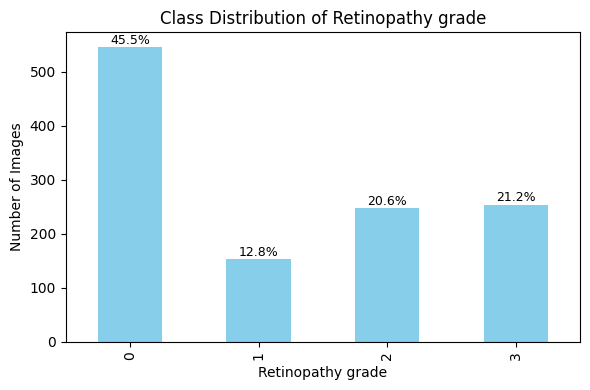

In [9]:
# Plot Class Distribution

# Compute class distribution and percentages
class_counts = df['label'].value_counts().sort_index()
class_percentages = (class_counts / class_counts.sum()) * 100

# Plot bar chart
plt.figure(figsize=(6, 4))
ax = class_counts.plot(kind='bar', color='skyblue')

# Add title and labels
plt.title("Class Distribution of " + health_condition)
plt.xlabel(health_condition)
plt.ylabel("Number of Images")
plt.grid(False)
plt.tight_layout()

# Annotate bars with percentage values
for i, (count, pct) in enumerate(zip(class_counts, class_percentages)):
    ax.text(i, count + 1, f'{pct:.1f}%', ha='center', va='bottom', fontsize=9)

plt.show()


--- Images Metadata ---
Image: 20060412_58032_0200_PP.tif, grade:0 Retinopathy grade, shape: 360×240, # channels: C:3, Image depth:uint8
Image: 20060412_59400_0200_PP.tif, grade:1 Retinopathy grade, shape: 360×240, # channels: C:3, Image depth:uint8
Image: 20060522_45455_0100_PP.tif, grade:2 Retinopathy grade, shape: 560×372, # channels: C:3, Image depth:uint8
Image: 20060412_57680_0200_PP.tif, grade:3 Retinopathy grade, shape: 360×240, # channels: C:3, Image depth:uint8
-----------------------


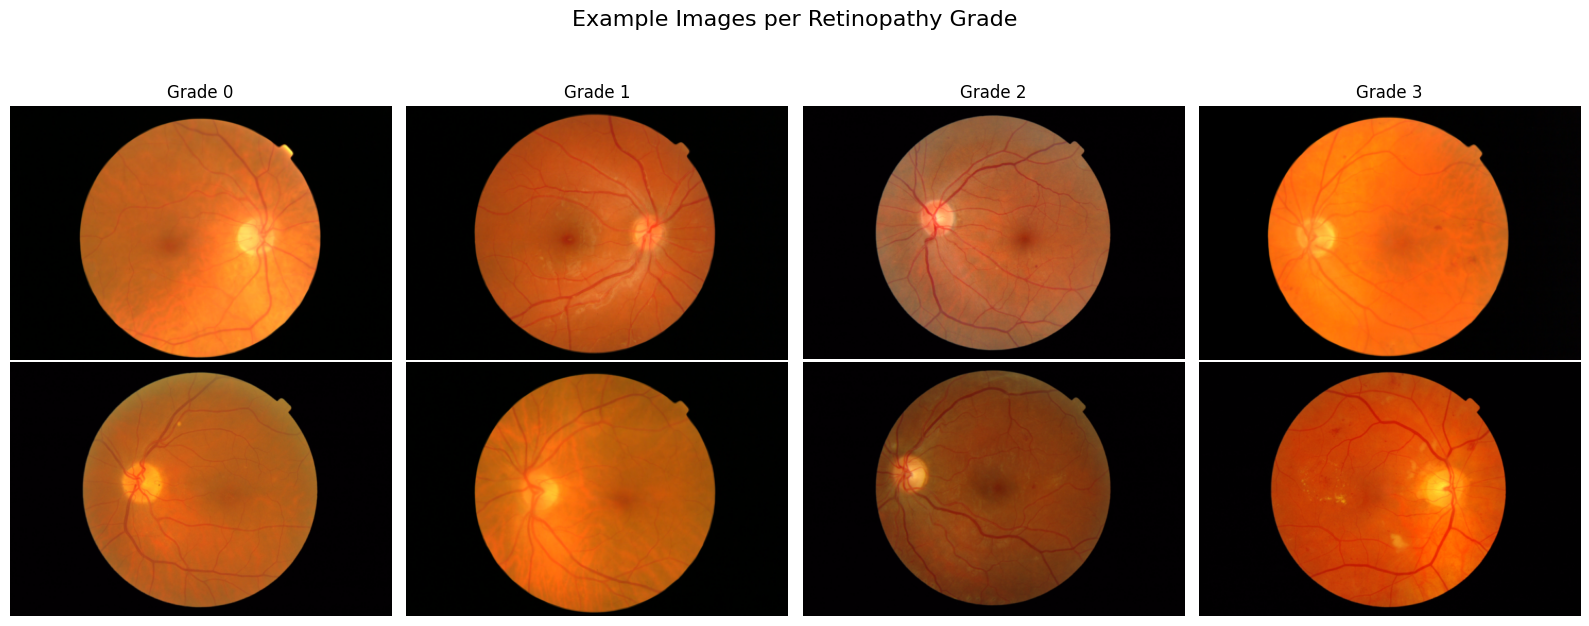

In [10]:
# Display Sample Images from Each Class
# Parameters
classes = sorted(df['label'].unique())
examples_per_class = 2
num_classes = len(classes)

# Set up the grid: rows = examples, columns = classes
fig, axes = plt.subplots(nrows=examples_per_class, ncols=num_classes, figsize=(num_classes * 4, examples_per_class * 3))
fig.suptitle("Example Images per Retinopathy Grade", fontsize=16, y=1.05)

print("--- Images Metadata ---")
# Plot examples_per_class random examples per class
for col, label in enumerate(classes):
    class_df = df[df['label'] == label]
    samples = class_df.sample(n=min(examples_per_class, len(class_df)), random_state=seed)

    for row in range(examples_per_class):
        ax = axes[row, col] if examples_per_class > 1 else axes[col]
        if row < len(samples):
            image_path = samples.iloc[row]['image_path']
            try:
                image = Image.open(image_path)
                img_array = np.array(image)

                # Extract image metadata
                width, height = image.size
                channels = 1 if len(img_array.shape) == 2 else img_array.shape[2]
                dtype = img_array.dtype

                if row == 0:
                    print(f"Image: {os.path.basename(image_path)}, grade:{label} {health_condition}, shape: {width}×{height}, # channels: C:{channels}, Image depth:{dtype}")

                # Show image
                ax.imshow(image)
                ax.axis('off')

                # Set column title in the top row
                if row == 0:
                    ax.set_title(f"Grade {label}", fontsize=12)

            except Exception as e:
                #ax.axis('off')
                ax.set_title("Error loading image")
                print(f"⚠️ Failed to load image {image_path}: {e}")
        else:
            ax.axis('off')
print("-----------------------")
plt.tight_layout()
plt.show()



#### ⚠️ **Issues Identified**

1. **Unbalanced Classes:**
   
- Some classes are significantly underrepresented in the dataset.
- This can lead to biased models that perform well on majority classes but poorly on minority ones.

2. **Rectangular images with black space (no information os the sides):**

- Images are not square, and contain unnecessary dark parts  on the sides 
- These side regions can mislead the model during training and reduce generalization.

#### ✅ **Solutions for robust data preparation**

1. **Unbalanced Classes:**
- Data Augmentation: Apply random flips, rotations, intensity variations, and elastic deformations more frequently to minority class images.
- Oversampling: Duplicate or synthetically generate samples from underrepresented classes.
- **Class-Aware Sampling: Implement sampling strategies that ensure a balanced batch distribution during training.**
- Loss Reweighting: Use class-weighted loss functions (e.g., weighted cross-entropy, focal loss) to penalize errors on minority classes more heavily.

1. **Rectangular images with black space:**
- Cropping: Automatically crop the central region of interest (ROI).
- Padding and Resizing: Pad images to square shape while preserving aspect ratio

## 3.5. Data Preparation

### 3.5.1. Input parameters

In [11]:
# Image size and batch settings
image_size = (224, 224)
batch_size = 32
#num_workers = 8  # Adjust based on your hardware, suggeste half of teh avaible ones
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]


### 3.5.2. Data Splitting: Train, Validation, Test

In [12]:
# Split proportions
test_size = 0.2       # 20% of the total dataset for testing
val_size = 0.2        # 20% of the training data for validation (i.e., 16% of total)

# First split: train + val and test
train_val_df, test_df = train_test_split(
    df,
    test_size=test_size,
    stratify=df['label'], # For unbalanced data to make the split even
    random_state=seed
)

# Second split: train and val from train_val_df
train_df, val_df = train_test_split(
    train_val_df,
    test_size=val_size,
    stratify=train_val_df['label'],  # For unbalanced data to make the split even
    random_state=seed
)


# Print Summary: Class Counts and Percentages

def print_distribution(name, subset):
    counts = subset['label'].value_counts().sort_index()
    percentages = subset['label'].value_counts(normalize=True).sort_index() * 100
    print(f"\n📊 {name} set:")
    for label in counts.index:
        print(f"  Class {label}: {counts[label]} images ({percentages[label]:.2f}%)")

print_distribution("Train", train_df)
print_distribution("Validation", val_df)
print_distribution("Test", test_df)



📊 Train set:
  Class 0: 350 images (45.57%)
  Class 1: 98 images (12.76%)
  Class 2: 158 images (20.57%)
  Class 3: 162 images (21.09%)

📊 Validation set:
  Class 0: 87 images (45.31%)
  Class 1: 24 images (12.50%)
  Class 2: 40 images (20.83%)
  Class 3: 41 images (21.35%)

📊 Test set:
  Class 0: 109 images (45.42%)
  Class 1: 31 images (12.92%)
  Class 2: 49 images (20.42%)
  Class 3: 51 images (21.25%)


### 3.5.3. Custom Dataset Class

In [13]:
class RetinaDataset(Dataset):
    """
    Custom Dataset for RGB retinal image classification.
    Performs bounding box cropping, 
    and applies additional transformations.
    """
    def __init__(self, dataframe, data_dir, transform=None):
        """
        Parameters:
        - dataframe (pd.DataFrame): Must contain 'image_name' and 'label' columns.
        - data_dir (str): Path to image directory.
        - transform (callable, optional): Torchvision transforms to apply.
        """
        self.df = dataframe.reset_index(drop=True)
        self.data_dir = data_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    
    def bounding_box_crop(self, img):
        """
        Crops the smallest bounding box around non-black pixels and pads it with zeros
        to create a square image with side length equal to the max side + 5 pixels.
    
        Parameters:
        img (PIL.Image): Input RGB image.
    
        Returns:
        PIL.Image: Cropped and padded RGB image.
        """
        # Convert PIL to OpenCV format (RGB to BGR)
        img_cv = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    
        # Convert to grayscale
        gray = cv2.cvtColor(img_cv, cv2.COLOR_BGR2GRAY)
    
        # Create binary mask of non-black areas
        _, mask = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        # Ensure mask has the same number of channels as the image
        mask_3ch = cv2.merge([mask, mask, mask])  # Convert single-channel to 3-channel mask
        
        # Apply mask to image (zero out background)
        img_cv = cv2.bitwise_and(img_cv, mask_3ch)

        # Get non-zero (non-black) coordinates
        coords = cv2.findNonZero(mask)
    
        if coords is None:
            print("⚠️ Image is completely black. Skipping crop.")
            return img
    
        # Bounding box
        x, y, w, h = cv2.boundingRect(coords)
    
        # Crop to bounding box
        cropped = img_cv[y:y+h, x:x+w]

        # Determine new square size
        max_side = max(w, h) 
        max_side += int(0.1 * max_side) 
    
        # Create black square canvas
        padded = np.zeros((max_side, max_side, 3), dtype=np.uint8) 

    
        # Compute top-left coordinates to center the cropped image
        y_offset = (max_side - h) // 2
        x_offset = (max_side - w) // 2
    
        # Paste the cropped image onto the center of the black square
        padded[y_offset:y_offset+h, x_offset:x_offset+w] = cropped
    
        # Convert back to PIL format
        result_img = Image.fromarray(cv2.cvtColor(padded, cv2.COLOR_BGR2RGB))
    
        return result_img  

    def preprocessing(self, img, apply_clahe=True):
        """
        Applies Ben Graham preprocessing with optional CLAHE to a fundus image.
    
        Parameters:
        - img: Input image (RGB as NumPy array or PIL Image)
        - apply_clahe: Whether to apply CLAHE to enhance local contrast
    
        Returns:
        - Preprocessed image as PIL Image (RGB)
        """
        # Ensure image is a NumPy array in RGB
        if isinstance(img, Image.Image):
            img = np.array(img)

        mask = img > 0 
        mask = 255 * mask.astype(np.uint8)
        
       # Convert RGB to BGR for OpenCV operations
        img_bgr = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    
        # Apply CLAHE 
        if apply_clahe:
            lab = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2LAB)
            l, a, b = cv2.split(lab)
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
            l_clahe = clahe.apply(l)
            a_clahe = clahe.apply(a)
            b_clahe = clahe.apply(b)
            lab = cv2.merge((l_clahe, a_clahe, b_clahe))
            img_bgr = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
    
        # Normalize to [0, 1] and convert to RGB for PIL
        img_bgr = np.clip(img_bgr, 0, 255).astype(np.uint8)
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

        # Apply mask to image (zero out background)
        img_rgb = cv2.bitwise_and(img_rgb, mask)

       
        return Image.fromarray(img_rgb)

    
    def __getitem__(self, idx):
        """
        Loads an RGB image, applies bounding box crop, and transforms.
        Returns:
        - image (Tensor or PIL.Image): Preprocessed image
        - label (int): Corresponding class label
        """
        try:
            image_name = self.df.iloc[idx]['image_name']
            label = int(self.df.iloc[idx]['label'])

            img_path = os.path.join(self.data_dir, image_name)
            image = Image.open(img_path).convert("RGB")  # ensure RGB

            image = self.bounding_box_crop(image)        # crop to content       
            image = self.preprocessing(image, apply_clahe=True) # Image preprocessing
    
            if self.transform:
                image = self.transform(image)

            return image, label

        except Exception as e:
            print(f"⚠️ Error loading image at index {idx}: {e}")
            return None, None



### 3.5.4. Define transformations and data augmentation

In [14]:
# Data augmentation + preprocessing for training
train_transform = transforms.Compose([
    transforms.Resize(image_size),                     # Resize image to fixed size
    transforms.RandomHorizontalFlip(p=0.5),            # Random horizontal flip: Increases symmetry: retinas are often symmetric
    #transforms.RandomVerticalFlip(p=0.5),             # Random vertical flip    ! No physiological 
    transforms.RandomRotation(degrees=20),              # Random rotation: Simulates head tilt, camera rotation
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), #Color Jitter simulates variation across devices
    transforms.ToTensor(),                             # Convert PIL Image to tensor
    transforms.Normalize(mean=imagenet_mean,          # Normalize for pretrained models
                         std=imagenet_std)
])

# Preprocessing only for validation and testing
val_test_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean,
                        std=imagenet_std)
])

### 3.5.5. Create datasets and data loaders

In [15]:
def create_balanced_sampler(labels):
    """
    Creates a WeightedRandomSampler to handle class imbalance.

    Parameters:
    - labels (list or np.array): Class labels for each sample in the dataset.

    Returns:
    - sampler: PyTorch WeightedRandomSampler for use in DataLoader
    """
    # Convert to numpy array if not already
    labels = np.array(labels)

    # Count how many samples belong to each class
    class_counts = np.bincount(labels)
    #print(f"📊 Class counts: {dict(enumerate(class_counts))}")

    # Assign higher weight to underrepresented classes
    class_weights = np.where(class_counts == 0, 0, 1. / class_counts)

    # Weight per sample
    sample_weights = class_weights[labels]

    # Define the sampler
    sampler = WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(sample_weights),
        replacement=True
    )

    return sampler


In [16]:
# Create datasets
train_dataset = RetinaDataset(train_df, data_dir, transform=train_transform)
val_dataset = RetinaDataset(val_df, data_dir, transform=val_test_transform)
test_dataset = RetinaDataset(test_df, data_dir, transform=val_test_transform)

# Create balanced sampler for training set
train_labels = train_df['label'].values
train_sampler = create_balanced_sampler(train_labels)

# Create DataLoaders
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    sampler=train_sampler,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle= False,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle= False,

)

### 3.5.6. Plot dataset batches

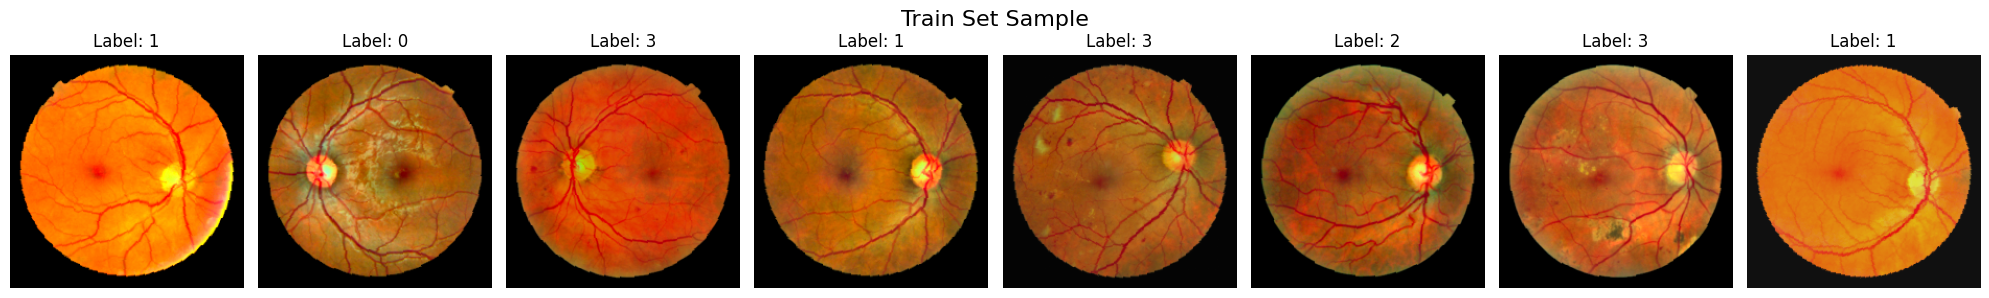

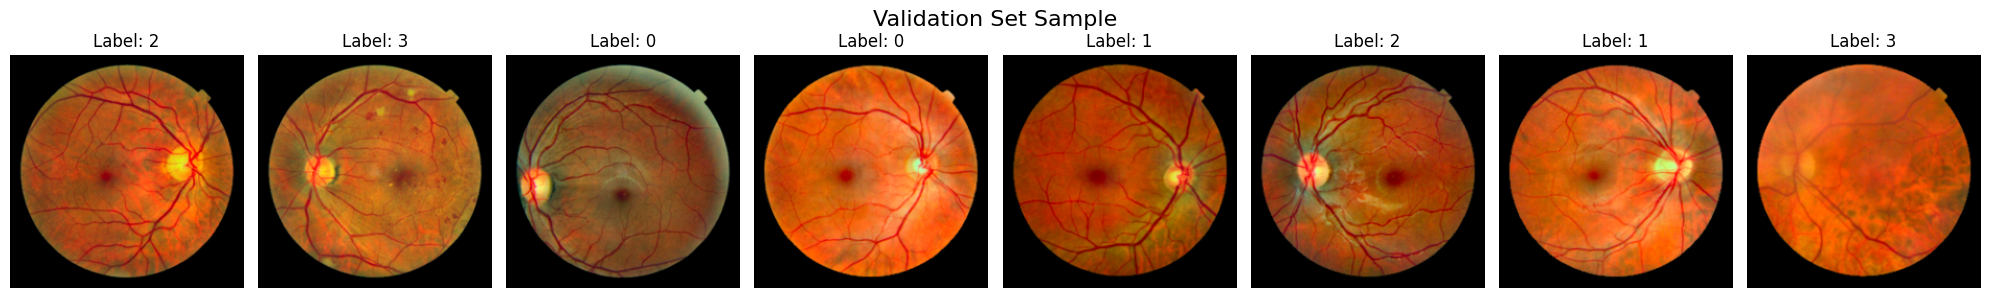

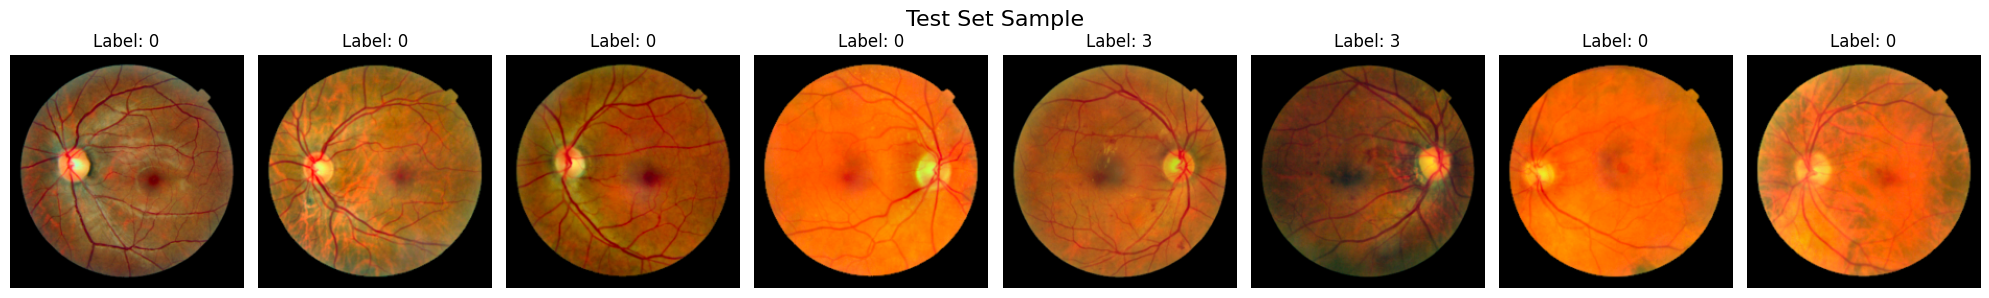

In [17]:
def plot_batch(loader, title="Batch from DataLoader", max_images=8):
    """
    Displays a batch of images from a DataLoader.

    Parameters:
    - loader: PyTorch DataLoader
    - title: Title for the plot
    - max_images: Maximum number of images to show (default: 8)
    """
    imagenet_mean = [0.485, 0.456, 0.406]
    imagenet_std = [0.229, 0.224, 0.225]

    images, labels = next(iter(loader))
    num_images = min(len(images), max_images)

    fig, axs = plt.subplots(1, num_images, figsize=(num_images * 2.5, 3))
    fig.suptitle(title, fontsize=16)

    for idx in range(num_images):
        ax = axs[idx] if num_images > 1 else axs

        img = images[idx]
        label = labels[idx]

        # Ensure mean and std are tensors shaped for broadcasting
        imagenet_mean = torch.tensor(imagenet_mean).view(-1, 1, 1)
        imagenet_std = torch.tensor(imagenet_std).view(-1, 1, 1)
        
        # Unnormalize and clip between 0 and 1
        img = img * imagenet_std + imagenet_mean
        img = torch.clamp(img, 0, 1)


        # Handle grayscale (1 channel) and RGB (3 channels)
        if img.shape[0] == 1:
            ax.imshow(img[0], cmap='gray')
        else:
            ax.imshow(img.permute(1, 2, 0))  # Convert from (C, H, W) to (H, W, C)

        ax.set_title(f'Label: {label.item()}')
        ax.axis('off')

    plt.tight_layout()
    plt.show()


# Visualize Batches from All Datasets

plot_batch(train_loader, title="Train Set Sample")
plot_batch(val_loader, title="Validation Set Sample")
plot_batch(test_loader, title="Test Set Sample")


## 3.6. Model Definitions

### 3.6.1. Define models and load pretrained ones

In [18]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 56 * 56, 16),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(16, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


class SimpleCNNv2(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNNv2, self).__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # 3xHxW -> 32xHxW
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),  # Downsample: H/2 x W/2

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),  # Downsample again: H/4 x W/4

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2)  # Final downsampling: H/8 x W/8
        )

        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))  # Output shape: [batch, 128, 1, 1]
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.global_pool(x)
        x = self.classifier(x)
        return x

def get_pretrained_model(name, num_classes, pretrained=True):
    if name == "resnet18":
        model = models.resnet18(pretrained=pretrained)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    elif name == "resnet50":
        model = models.resnet50(pretrained=pretrained)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    elif name == "resnet152":
        model = models.resnet152(pretrained=pretrained)
        model.fc = nn.Linear(model.fc.in_features, num_classes)       
    else:
        raise ValueError("Model not supported.")
    return model


### 3.6.1. Define models to train

In [19]:
# Define model dictionary

model_dict = {
    "01_SimpleCNN_scratch ": lambda: SimpleCNN(num_classes).to("cuda"),
    "02_SimpleCNNv2_scratch ": lambda: SimpleCNNv2(num_classes).to("cuda"),
    "03_ResNet18_scratch ": lambda: get_pretrained_model("resnet18", num_classes, pretrained=False).to("cuda"),
    "04_ResNet18_pretrained": lambda: get_pretrained_model("resnet18", num_classes, pretrained=True).to("cuda"),
    "05_ResNet50_scratch": lambda: get_pretrained_model("resnet50", num_classes, pretrained=False).to("cuda"),
    "06_ResNet50_pretrained": lambda: get_pretrained_model("resnet50", num_classes, pretrained=False).to("cuda"),
    "07_ResNet152_scratch": lambda: get_pretrained_model("resnet152", num_classes, pretrained=True).to("cuda"),
    "08_ResNet152_pretrained": lambda: get_pretrained_model("resnet152", num_classes, pretrained=True).to("cuda"),
}


### 3.6.2. Generate and print summaries

In [20]:
'''
for model_name, model_fn in model_dict.items():
    print(f"\n🔍 Summary for: {model_name}")
    try:
        model = model_fn()
        summary(model, input_size=(3, *image_size))
    except Exception as e:
        print(f"⚠️ Could not generate summary: {e}")
     '''

'\nfor model_name, model_fn in model_dict.items():\n    print(f"\n🔍 Summary for: {model_name}")\n    try:\n        model = model_fn()\n        summary(model, input_size=(3, *image_size))\n    except Exception as e:\n        print(f"⚠️ Could not generate summary: {e}")\n     '

## 3.7.  Training models with early stopping

### 3.7.1.  Define Early stopping to avoid overfitting

In [21]:
class EarlyStopping:
    """
    Early stopping utility to stop training when validation loss doesn't improve.
    """
    def __init__(self, patience=5, min_delta=0.0, verbose=True, save_best_only=True):
        self.patience = patience
        self.min_delta = min_delta
        self.verbose = verbose
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False
        self.save_best_only = save_best_only
        self.best_model = None

    def __call__(self, val_loss: float, model: nn.Module):
        if val_loss < self.best_loss - self.min_delta:
            if self.verbose:
                print(f"Validation loss improved from {self.best_loss:.4f} to {val_loss:.4f}. Saving model...")
            self.best_loss = val_loss
            self.best_model = model.state_dict()
            self.counter = 0
        else:
            self.counter += 1
            if self.verbose:
                print(f"No improvement. EarlyStopping counter: {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True


### 3.7.2. Define training loop

In [22]:
def train_model(model, train_loader, val_loader, num_epochs, model_name, learning_rate=1e-4):
    """
    Train a model with early stopping and TensorBoard logging.

    Parameters:
    - model: the PyTorch model to train
    - train_loader, val_loader: DataLoaders
    - num_epochs: number of max training epochs
    - model_name: name for logging/saving
    - learning_rate: optimizer learning rate
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    early_stopper = EarlyStopping(patience=5, min_delta=1e-4, verbose=True)

    writer = SummaryWriter(log_dir=f'runs/{model_name}_{int(time.time())}')

    for epoch in range(num_epochs):
        start_time = time.time()

        # Training loop
        model.train()
        train_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Validation loop
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        epoch_time = time.time() - start_time

        # Logging
        writer.add_scalars('Loss', {
            'train': avg_train_loss,
            'val': avg_val_loss
        }, epoch)

        print(f"Epoch {epoch+1}/{num_epochs} - "
              f"Train Loss: {avg_train_loss:.4f}, "
              f"Val Loss: {avg_val_loss:.4f}, "
              f"Time: {epoch_time:.2f}s")

        # Check early stopping
        early_stopper(avg_val_loss, model)
        if early_stopper.early_stop:
            print("🛑 Early stopping triggered.")
            break

    # Restore best model weights
    model.load_state_dict(early_stopper.best_model)
    torch.save(model.state_dict(), f"{model_name}.pth")
    writer.close()

    return model


### 3.7.3. Train all models

In [23]:
# Define base log directory
log_root = "runs_all_models"
os.makedirs(log_root, exist_ok=True)

# Update model dictionary to avoid overwriting logs
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

for model_name, model_fn in model_dict.items():
    print(f"\n🚀 Training model: {model_name}")
    try:
        model = model_fn()  # Already moved to CUDA
        log_name = f"{model_name.replace(' ', '_')}_{timestamp}"
        trained_model = train_model(
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            num_epochs=100,
            model_name=os.path.join(log_root, log_name),
            learning_rate=1e-5
        )
    except Exception as e:
        print(f"⚠️ Failed to train {model_name}: {e}")



🚀 Training model: 01_SimpleCNN_scratch 
Epoch 1/100 - Train Loss: 1.3982, Val Loss: 1.3533, Time: 24.86s
Validation loss improved from inf to 1.3533. Saving model...
Epoch 2/100 - Train Loss: 1.3901, Val Loss: 1.3533, Time: 19.02s
No improvement. EarlyStopping counter: 1/5
Epoch 3/100 - Train Loss: 1.3910, Val Loss: 1.3810, Time: 18.13s
No improvement. EarlyStopping counter: 2/5
Epoch 4/100 - Train Loss: 1.3846, Val Loss: 1.4194, Time: 17.33s
No improvement. EarlyStopping counter: 3/5
Epoch 5/100 - Train Loss: 1.3918, Val Loss: 1.3533, Time: 17.23s
No improvement. EarlyStopping counter: 4/5
Epoch 6/100 - Train Loss: 1.3908, Val Loss: 1.3533, Time: 16.97s
No improvement. EarlyStopping counter: 5/5
🛑 Early stopping triggered.

🚀 Training model: 02_SimpleCNNv2_scratch 
Epoch 1/100 - Train Loss: 1.4113, Val Loss: 1.3979, Time: 17.56s
Validation loss improved from inf to 1.3979. Saving model...
Epoch 2/100 - Train Loss: 1.4071, Val Loss: 1.4184, Time: 17.27s
No improvement. EarlyStopping c

### 3.7.4. Launch TensorBoard

In [24]:
# In a Jupyter notebook cell
%reload_ext tensorboard
%tensorboard --logdir runs/runs_all_models --port 6007


Reusing TensorBoard on port 6007 (pid 2896), started 3:19:12 ago. (Use '!kill 2896' to kill it.)

## 3.8. Evaluation on Test Set

### 3.8.1. Define evaluation function

In [25]:

def evaluate_model(model, model_name, dataloader, class_names):
    """
    Evaluate a multi-class model and generate reports, AUC-ROC curves, and confusion matrix.

    Args:
        model (nn.Module): Trained model.
        model_name (str): Name for display in plots and logs.
        dataloader (DataLoader): Dataloader for test or validation data.
        class_names (list[str]): List of class names.

    Returns:
        tuple: (confusion matrix, classification report as dict, auc_macro)
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    y_true, y_pred, y_score = [], [], []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1).cpu().numpy()

            y_score.extend(probs)
            y_pred.extend(np.argmax(probs, axis=1))
            y_true.extend(labels.cpu().numpy())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_score = np.array(y_score)

    # Classification report
    print(f"\n📊 Classification Report for: {model_name}")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap='Blues', xticks_rotation=45, colorbar=False)
    plt.title(f"Confusion Matrix - {model_name}")
    plt.grid(False)
    plt.tight_layout()
    plt.show()

    # ROC-AUC (One-vs-Rest, macro average)
    y_true_bin = label_binarize(y_true, classes=range(len(class_names)))
    auc_macro = roc_auc_score(y_true_bin, y_score, multi_class='ovr', average='macro')
    print(f"\n📈 Macro AUC-ROC (OvR): {auc_macro:.4f}")

    # Plot ROC curves per class
    fpr = {}
    tpr = {}
    for i in range(len(class_names)):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])

    plt.figure(figsize=(8, 6))
    for i, class_name in enumerate(class_names):
        plt.plot(fpr[i], tpr[i], label=f'{class_name} (AUC = {roc_auc_score(y_true_bin[:, i], y_score[:, i]):.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curves - {model_name}')
    plt.legend()
    plt.grid(True)
    plt.show()

    return cm, classification_report(y_true, y_pred, target_names=class_names, output_dict=True), auc_macro

### 3.8.2. Evaluate all trained models on the test set


🔍 Loading and evaluating: 01_SimpleCNN_scratch  from  01_SimpleCNN_scratch__20250618_001444.pth

📊 Classification Report for: 01_SimpleCNN_scratch 
              precision    recall  f1-score   support

     Grade 0       0.45      1.00      0.62       109
     Grade 1       0.00      0.00      0.00        31
     Grade 2       0.00      0.00      0.00        49
     Grade 3       0.00      0.00      0.00        51

    accuracy                           0.45       240
   macro avg       0.11      0.25      0.16       240
weighted avg       0.21      0.45      0.28       240



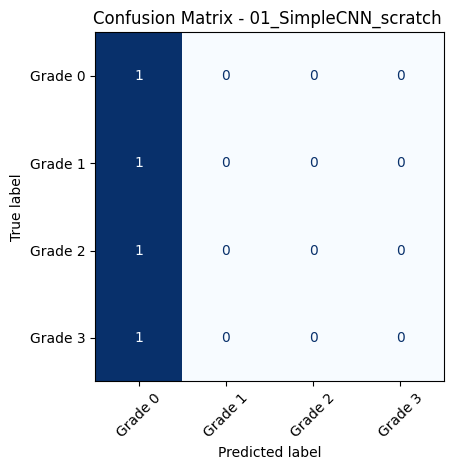


📈 Macro AUC-ROC (OvR): 0.5000


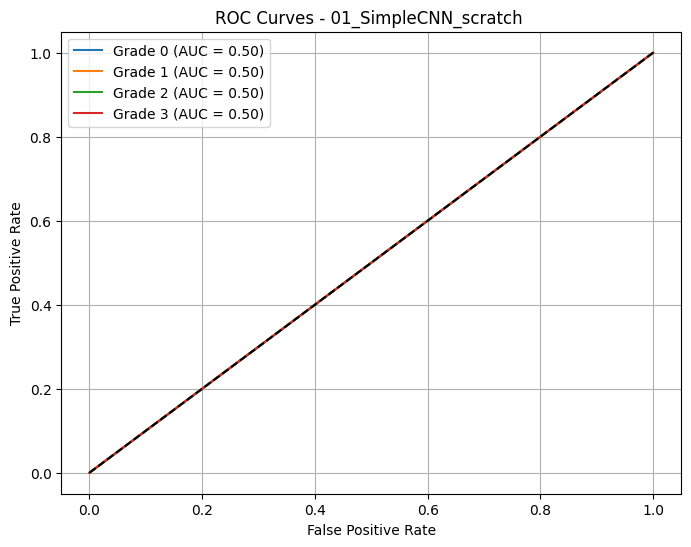


🔍 Loading and evaluating: 02_SimpleCNNv2_scratch  from  02_SimpleCNNv2_scratch__20250618_001444.pth

📊 Classification Report for: 02_SimpleCNNv2_scratch 
              precision    recall  f1-score   support

     Grade 0       0.54      0.41      0.47       109
     Grade 1       0.16      0.39      0.23        31
     Grade 2       0.24      0.12      0.16        49
     Grade 3       0.25      0.29      0.27        51

    accuracy                           0.33       240
   macro avg       0.30      0.30      0.28       240
weighted avg       0.37      0.33      0.33       240



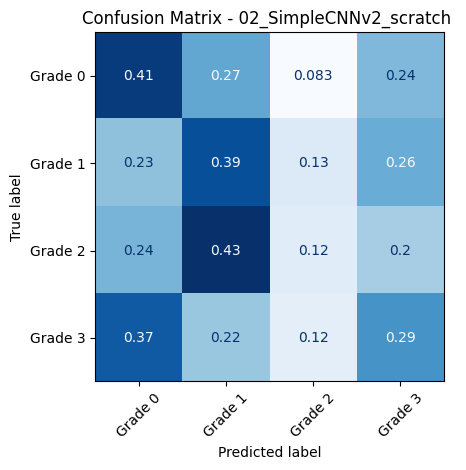


📈 Macro AUC-ROC (OvR): 0.5539


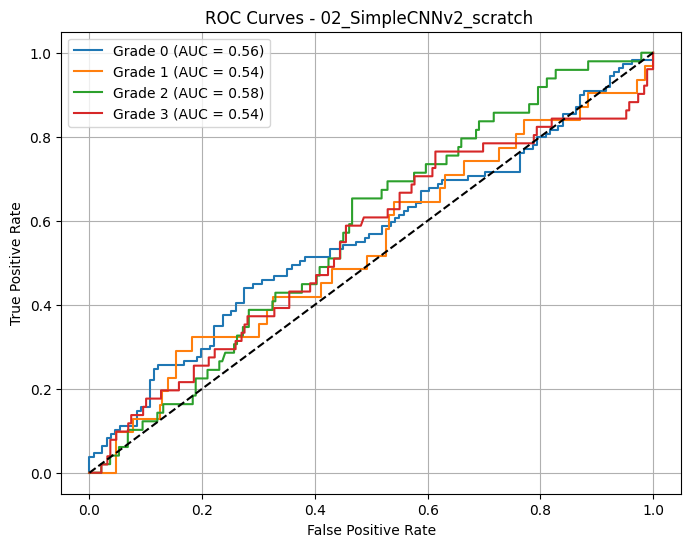


🔍 Loading and evaluating: 03_ResNet18_scratch  from  03_ResNet18_scratch__20250618_001444.pth

📊 Classification Report for: 03_ResNet18_scratch 
              precision    recall  f1-score   support

     Grade 0       0.57      0.50      0.53       109
     Grade 1       0.18      0.45      0.26        31
     Grade 2       0.31      0.18      0.23        49
     Grade 3       0.30      0.24      0.26        51

    accuracy                           0.37       240
   macro avg       0.34      0.34      0.32       240
weighted avg       0.41      0.37      0.38       240



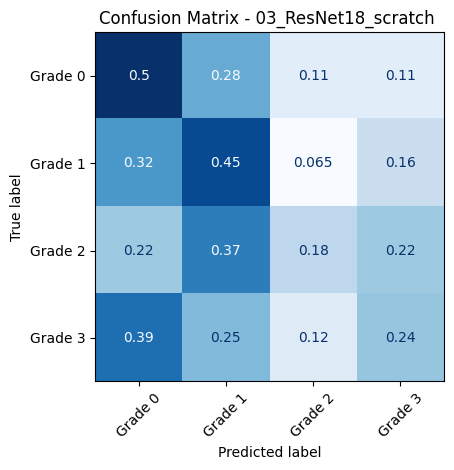


📈 Macro AUC-ROC (OvR): 0.5826


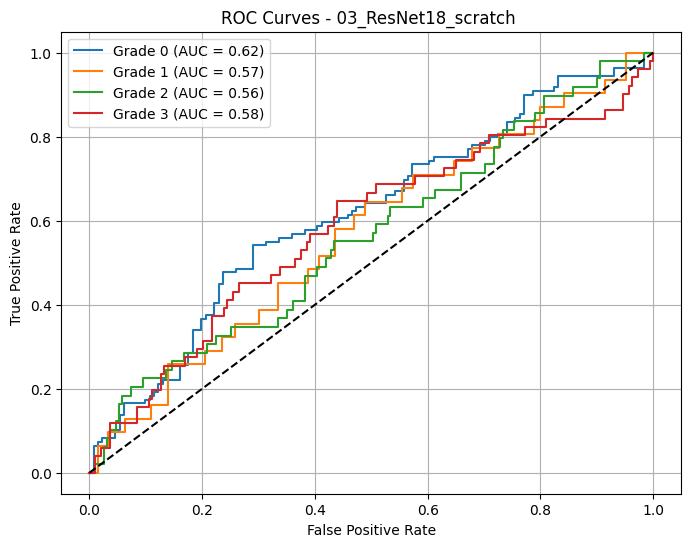


🔍 Loading and evaluating: 04_ResNet18_pretrained from  04_ResNet18_pretrained_20250618_001444.pth

📊 Classification Report for: 04_ResNet18_pretrained
              precision    recall  f1-score   support

     Grade 0       0.72      0.52      0.61       109
     Grade 1       0.26      0.52      0.34        31
     Grade 2       0.37      0.29      0.32        49
     Grade 3       0.62      0.75      0.68        51

    accuracy                           0.52       240
   macro avg       0.49      0.52      0.49       240
weighted avg       0.57      0.52      0.53       240



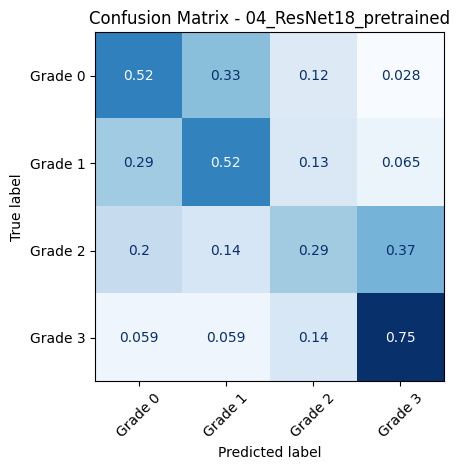


📈 Macro AUC-ROC (OvR): 0.7722


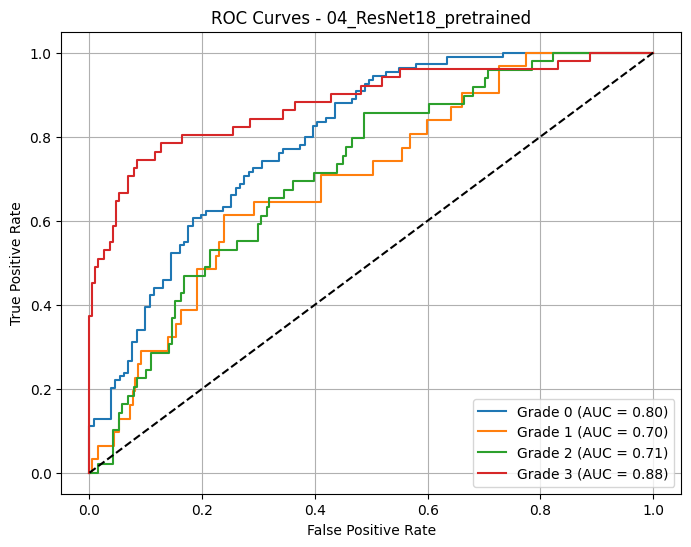


🔍 Loading and evaluating: 05_ResNet50_scratch from  05_ResNet50_scratch_20250618_001444.pth

📊 Classification Report for: 05_ResNet50_scratch
              precision    recall  f1-score   support

     Grade 0       0.65      0.16      0.25       109
     Grade 1       0.14      0.26      0.18        31
     Grade 2       0.24      0.69      0.36        49
     Grade 3       0.07      0.02      0.03        51

    accuracy                           0.25       240
   macro avg       0.28      0.28      0.20       240
weighted avg       0.38      0.25      0.22       240



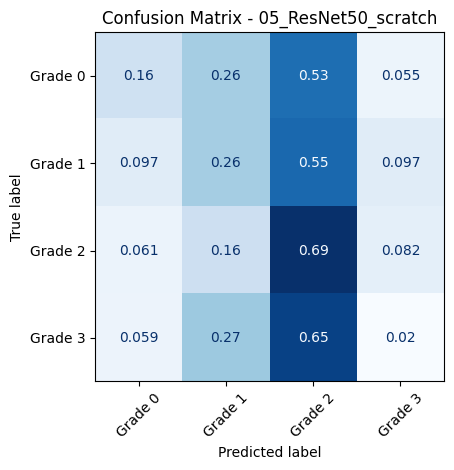


📈 Macro AUC-ROC (OvR): 0.5442


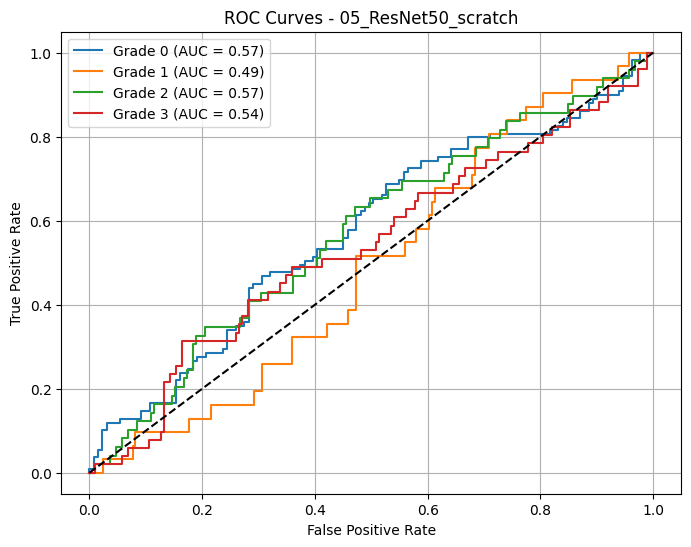


🔍 Loading and evaluating: 06_ResNet50_pretrained from  06_ResNet50_pretrained_20250618_001444.pth

📊 Classification Report for: 06_ResNet50_pretrained
              precision    recall  f1-score   support

     Grade 0       0.60      0.45      0.51       109
     Grade 1       0.11      0.39      0.17        31
     Grade 2       0.25      0.08      0.12        49
     Grade 3       0.21      0.14      0.17        51

    accuracy                           0.30       240
   macro avg       0.29      0.26      0.24       240
weighted avg       0.38      0.30      0.32       240



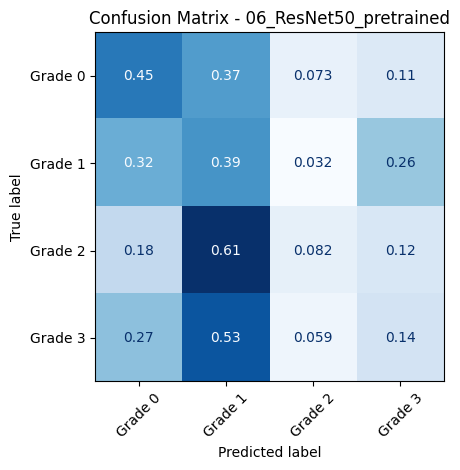


📈 Macro AUC-ROC (OvR): 0.5456


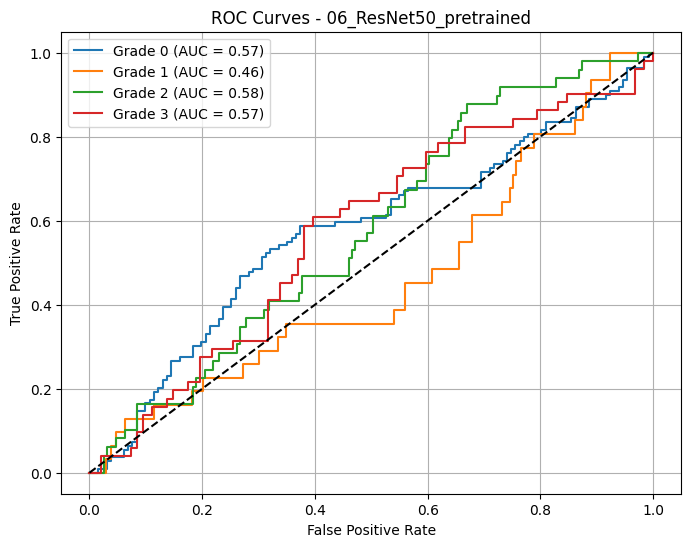


🔍 Loading and evaluating: 07_ResNet152_scratch from  07_ResNet152_scratch_20250618_001444.pth

📊 Classification Report for: 07_ResNet152_scratch
              precision    recall  f1-score   support

     Grade 0       0.73      0.75      0.74       109
     Grade 1       0.25      0.16      0.20        31
     Grade 2       0.37      0.45      0.41        49
     Grade 3       0.77      0.73      0.75        51

    accuracy                           0.61       240
   macro avg       0.53      0.52      0.52       240
weighted avg       0.60      0.61      0.60       240



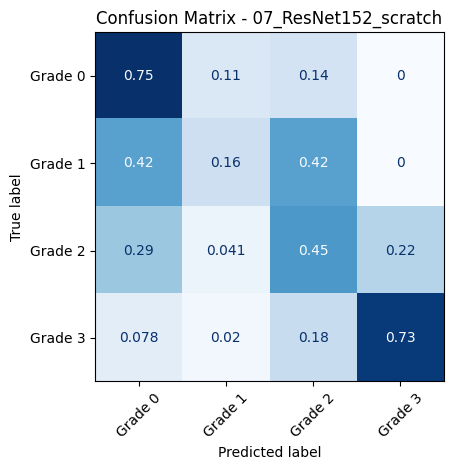


📈 Macro AUC-ROC (OvR): 0.7898


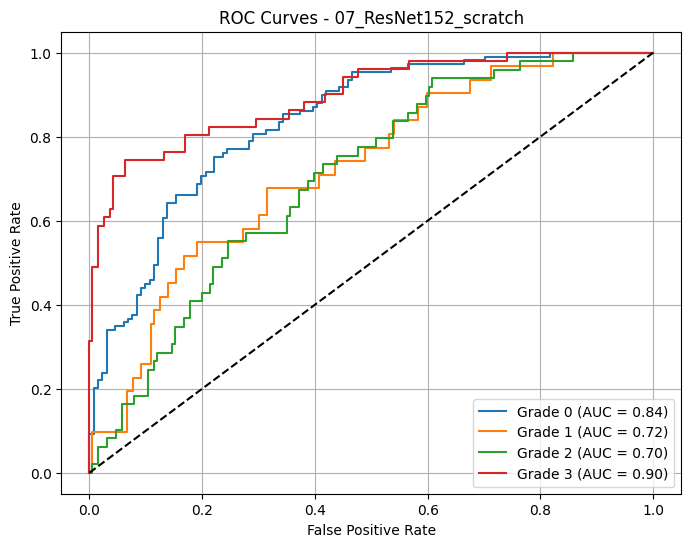


🔍 Loading and evaluating: 08_ResNet152_pretrained from  08_ResNet152_pretrained_20250618_001444.pth

📊 Classification Report for: 08_ResNet152_pretrained
              precision    recall  f1-score   support

     Grade 0       0.63      0.62      0.63       109
     Grade 1       0.24      0.35      0.29        31
     Grade 2       0.40      0.29      0.33        49
     Grade 3       0.71      0.71      0.71        51

    accuracy                           0.54       240
   macro avg       0.49      0.49      0.49       240
weighted avg       0.55      0.54      0.54       240



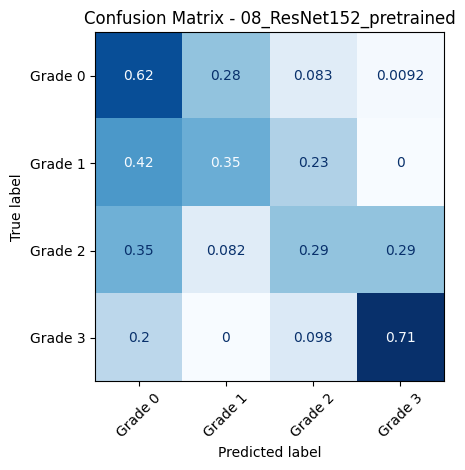


📈 Macro AUC-ROC (OvR): 0.7816


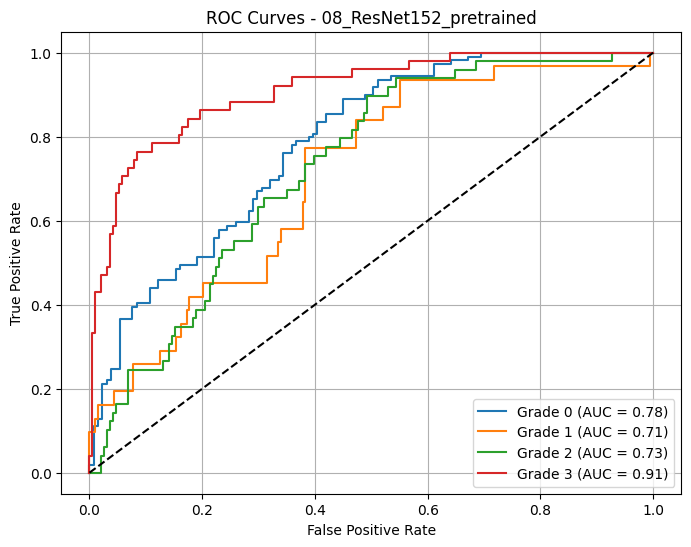

In [26]:
evaluation_results = {}

# Scan all .pth files in log_root
for file in os.listdir(log_root):
    if not file.endswith(".pth"):
        continue

    model_path = os.path.join(log_root, file)
    filename = os.path.basename(model_path)
    
    # Regex captures number prefix + model name
    match = re.match(r"(\d+_.+?)_+(\d{8}_\d{6})\.pth$", filename)
    
    if match:
        model_key = match.group(1).strip()  # e.g., '01_ResNet18_pretrained'
    else:
        model_key = filename.replace(".pth", "").strip()

    # Find matching model in dictionary
    matching_keys = [key for key in model_dict.keys() if key.startswith(model_key)]
    if not matching_keys:
        print(f"⚠️ No matching model found in model_dict for: {model_key}")
        continue

    model_name = matching_keys[0]
    print(f"\n🔍 Loading and evaluating: {model_name} from  {file}")

    # Load model
    model = model_dict[model_name]()
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)

    # Evaluate model
    cm, report, auc_macro = evaluate_model(model, model_name, test_loader, class_names=class_names)
    evaluation_results[model_name] = {
        "confusion_matrix": cm,
        "report": report,
        "auc_macro": auc_macro,
        "model_path": model_path,
    }


### 3.8.3. Get the Best Model by AUC-ROC Macro

In [27]:
# Find best model by AUC-ROC (macro average)
best_model = None
best_auc = -1.0

for model_name, metrics in evaluation_results.items():
    auc = metrics.get("auc_macro", 0)
    print(f"🔎 {model_name} - AUC-ROC (macro): {auc:.4f}")
    
    if auc > best_auc:
        best_auc = auc
        best_model = model_name

print("\n🏆 Best model based on AUC-ROC (macro):")
print(f"👉 {best_model} with AUC = {best_auc:.4f}")

🔎 01_SimpleCNN_scratch  - AUC-ROC (macro): 0.5000
🔎 02_SimpleCNNv2_scratch  - AUC-ROC (macro): 0.5539
🔎 03_ResNet18_scratch  - AUC-ROC (macro): 0.5826
🔎 04_ResNet18_pretrained - AUC-ROC (macro): 0.7722
🔎 05_ResNet50_scratch - AUC-ROC (macro): 0.5442
🔎 06_ResNet50_pretrained - AUC-ROC (macro): 0.5456
🔎 07_ResNet152_scratch - AUC-ROC (macro): 0.7898
🔎 08_ResNet152_pretrained - AUC-ROC (macro): 0.7816

🏆 Best model based on AUC-ROC (macro):
👉 07_ResNet152_scratch with AUC = 0.7898


## 3.9. Class Activation Maps (CAMs)

### 3.9.1. Define fucntion to create CAMs

In [42]:
def generate_cams(model, dataloader, target_layer='layer4', num_samples=10, class_names=None):
    """
    Generate and visualize CAMs (Class Activation Maps) for a given model and data loader.
    Displays them all in a grid of subplots.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()

    feature_extractor = create_feature_extractor(model, return_nodes={target_layer: "features"})

    try:
        if hasattr(model, 'fc'):
            softmax_weights = model.fc.weight.detach()
        elif hasattr(model, 'classifier'):
            if isinstance(model.classifier, nn.Sequential):
                softmax_weights = model.classifier[-1].weight.detach()
            else:
                softmax_weights = model.classifier.weight.detach()
        else:
            raise ValueError("Model must have a recognizable classifier layer (fc or classifier).")
    except Exception as e:
        raise ValueError(f"❌ Unable to extract classifier weights: {e}")
    
    overlays = []
    titles = []

    count = 0
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        with torch.no_grad():
            features = feature_extractor(images)["features"]
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

        batch_size = images.size(0)

        for i in range(batch_size):
            if count >= num_samples:
                break

            feature_map = features[i]  # [C, H, W]
            pred_class = preds[i].item()
            label_class = labels[i].item()

            cam = torch.matmul(softmax_weights[pred_class], feature_map.view(feature_map.shape[0], -1))
            cam = cam.view(feature_map.shape[1], feature_map.shape[2]).cpu().numpy()
            cam = cv2.resize(cam, (images.shape[3], images.shape[2]))
            cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-5)
            cam = np.uint8(255 * cam)
            heatmap = cv2.applyColorMap(cam, cv2.COLORMAP_JET)

            img_np = images[i].detach().cpu().numpy().transpose(1, 2, 0)
            img_np = np.clip(img_np, 0, 1)
            img_np = np.uint8(255 * img_np)

            # Convert to grayscale and then back to 3-channel image for overlay
            gray_img = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)
            img_np = cv2.cvtColor(gray_img, cv2.COLOR_GRAY2BGR)

            overlay = cv2.addWeighted(img_np, 0.7, heatmap, 0.3, 0)
            overlays.append(overlay[..., ::-1])  # Convert to RGB
            pred_label = class_names[pred_class] if class_names else f"Class {pred_class}"
            true_label = class_names[label_class] if class_names else f"Class {label_class}"
            titles.append(f"Pred: {pred_label}\nTrue: {true_label}")
            count += 1

        if count >= num_samples:
            break

    # 📊 Plot all images in a grid
    cols = min(5, num_samples)
    rows = math.ceil(num_samples / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 4*rows))

    for idx, ax in enumerate(axes.flat):
        if idx < len(overlays):
            ax.imshow(overlays[idx])
            ax.set_title(titles[idx], fontsize=10)
            ax.axis('off')
        else:
            ax.axis('off')

    plt.tight_layout()
    plt.show()

### 3.9.2. CAMs for the best models


🔍 Generating CAMs for: 07_ResNet152_scratch


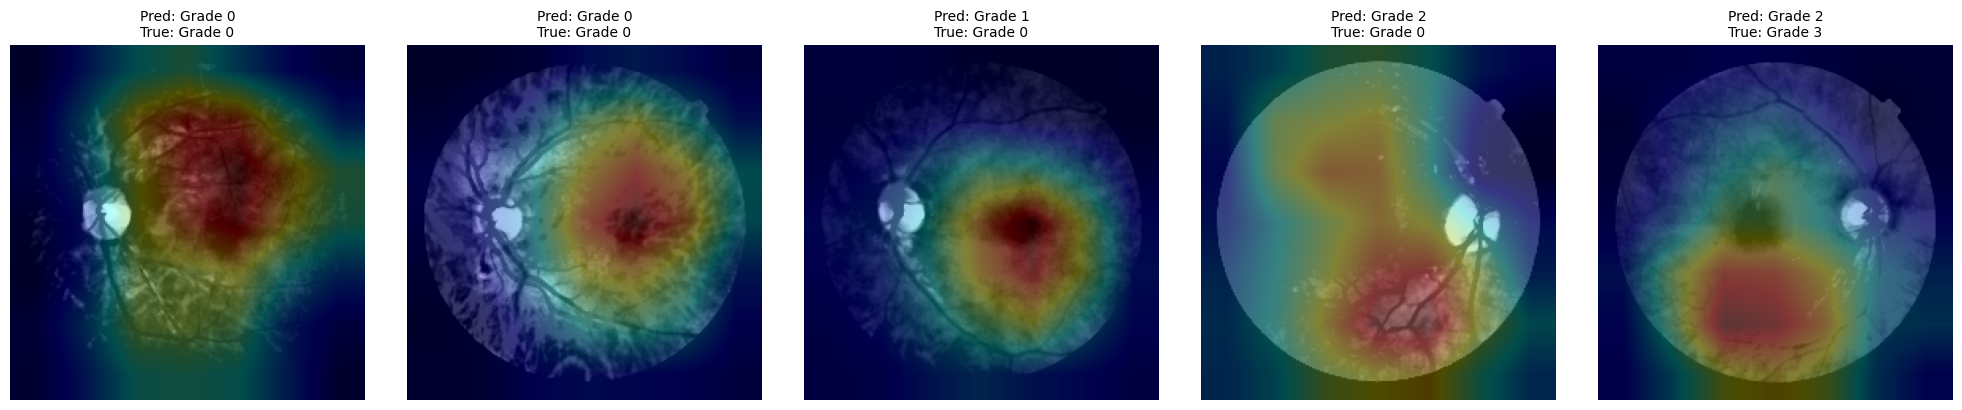


🔍 Generating CAMs for: 08_ResNet152_pretrained


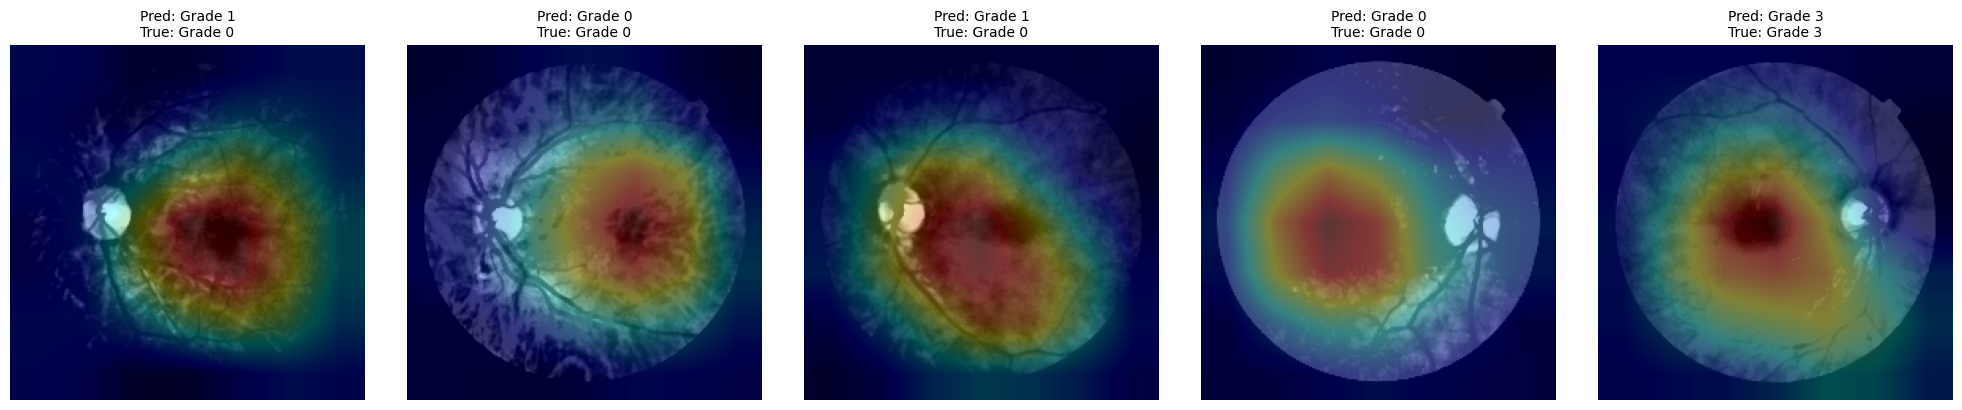


🔍 Generating CAMs for: 04_ResNet18_pretrained


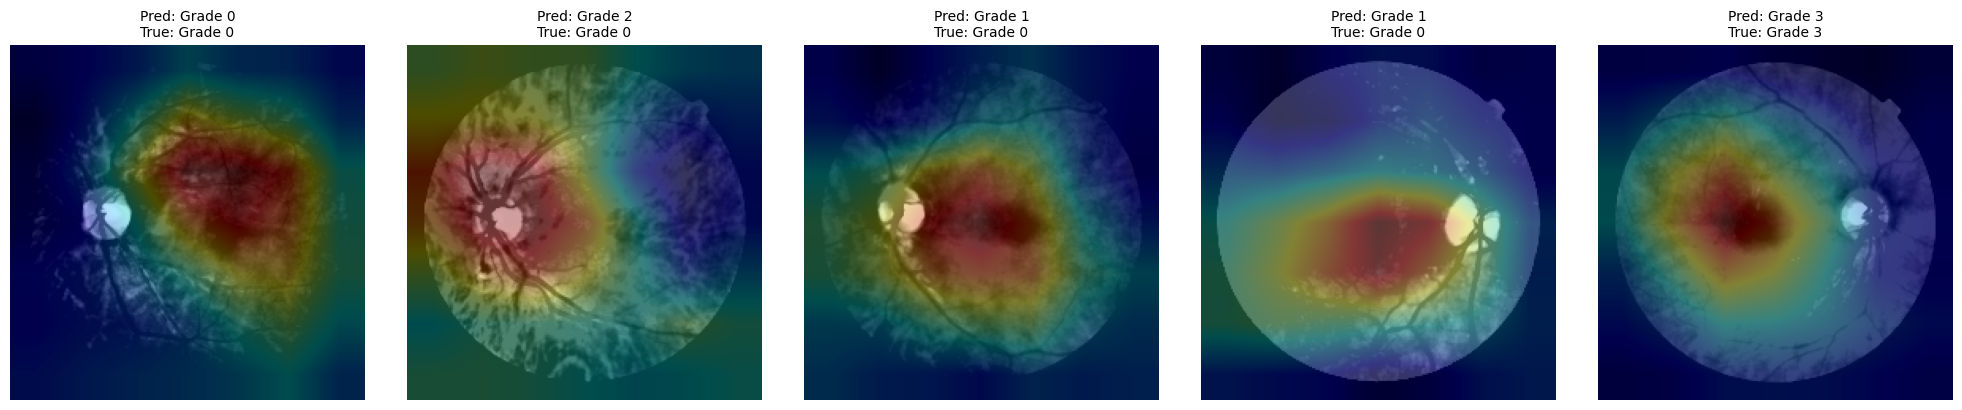

In [45]:
# ✅ Get Top 3 Models Based on AUC-ROC (macro)
top_3_models = sorted(
    evaluation_results.items(),
    key=lambda x: x[1].get("auc_macro", 0),
    reverse=True
)[:3]

# 🔁 Loop over top 3 models only
for model_name, _ in top_3_models:
    print(f"\n🔍 Generating CAMs for: {model_name}")

    if model_name not in model_dict:
        print(f"⚠️ Model '{model_name}' not found in all_models dictionary.")
        continue

    # Retrieve model
    model = model_dict[model_name]()
    model_path = evaluation_results[model_name]["model_path"]
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)

    # Determine appropriate target layer
    
    if 'resnet' in model_name.lower():
        target_layer = 'layer4'
    else:  # For custom CNNs
        target_layer = 'features.3'

    # Generate CAMs
    generate_cams(model, test_loader, target_layer=target_layer, num_samples=5, class_names=class_names)


# 4. Challenges & Limitations

## 4.1. Common implementation issues and solutions

### Imbalanced Dataset
- Problem: Diabetic retinopathy grading is often skewed toward lower severity classes.
- Solution: Apply weighted loss functions, oversampling techniques, or data augmentation to ensure balanced learning.

###  Overfitting with Small Datasets
- Problem: Custom CNNs may overfit due to limited training samples.
- Solution: Use pretrained models (transfer learning), dropout layers, data augmentation, and early stopping.

###  Incompatible Input Sizes
- Problem: Different CNN architectures expect different input shapes.
- Solution: Normalize input dimensions with transforms.Resize() and validate input shape compatibility before training.

###  CUDA/Device Errors
- Problem: Runtime crashes due to improper GPU memory usage or model placement.
- Solution: Always transfer models and tensors to the same device with .to(device) and monitor memory usage via nvidia-smi.

###  CAM Generation Failures
- Problem: Shape mismatch between classifier weights and feature map layers.
- Solution: Carefully select the correct target layer and confirm dimensions match before applying torch.matmul().

## 4.2. Technical and clinical limitations

### Generalization to Diverse Populations
CNNs trained on datasets like Messidor may not generalize well to populations with different demographic or imaging characteristics.

### Label Quality
Diagnostic labels used for training may contain inconsistencies or subjective bias from annotators, affecting model accuracy.

### Lack of Explainability
While CAMs offer some interpretability, CNNs are still largely black boxes, which may hinder clinical trust and adoption.

### Limited Edge Deployment
High-performance models require significant computational resources, which limits deployment in mobile or rural settings unless optimized.

### Binary vs. Multiclass Classification
Most tutorials simplify to binary classification (disease/no disease), while real-world diagnosis often demands nuanced, multiclass decisions - as sheown here more difficult to solve

## 4.3. Ethical considerations

### Bias in Data and Models
Unequal representation of ethnicities, ages, or imaging equipment can lead to biased predictions. Continuous audit of model fairness is essential.

###  Automation vs. Human Oversight
Fully automated decision-making in clinical practice is ethically risky. AI systems should assist, not replace, qualified ophthalmologists.